In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')
# # save the scaler to disk
# filename = 'latest_scaler_used.sav'
# joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 208), (57, 56, 56, 208))

# Test HybridSN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

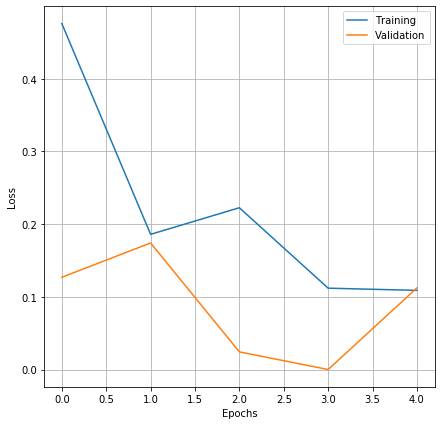

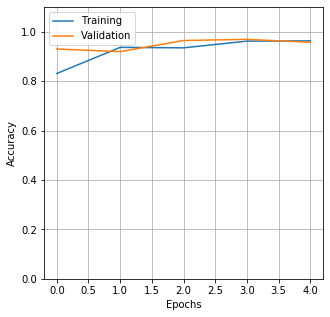

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     38469
         1.0       0.90      0.98      0.94     18652
         2.0       0.84      0.33      0.48      1247

    accuracy                           0.96     58368
   macro avg       0.91      0.76      0.80     58368
weighted avg       0.96      0.96      0.95     58368



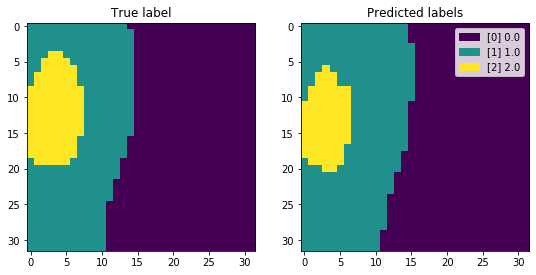

Elapsed time: 587.0667 seconds
Fasle positive blobs 22.
Fasle positive blobs per image 0.3860


In [4]:
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [5]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (1.6682685613632202, 73.80110931396484) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([1068233,  208047,   13960]))
(array([0., 1., 2.]), array([459515, 117070,   7095]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [7]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 208))

Elapsed time: 3882.7281 seconds
Elapsed time: 3875.6876 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1068233
         1.0       0.95      0.97      0.96    208047
         2.0       0.95      0.61      0.74     13960

    accuracy                           0.99   1290240
   macro avg       0.97      0.86      0.90   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 1754.3790 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    459515
         1.0       0.97      0.96      0.97    117070
         2.0       0.95      0.70      0.81      7095

    accuracy                           0.99    583680
   macro avg       0.97      0.89      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 24.
Fasle positive blobs per image 0.0421


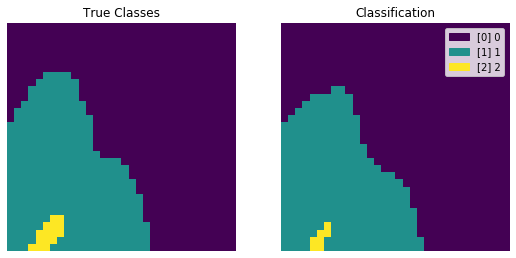

In [8]:
from sklearn import svm
from sklearn.metrics import classification_report

svm = mypackage.SVM(X_train_orig, Y_train_orig)
svm.train()
svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [9]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

Elapsed time: 1613.7096 seconds
Elapsed time: 0.8090 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1068233
         1.0       0.96      0.96      0.96    208047
         2.0       0.93      0.69      0.79     13960

    accuracy                           0.99   1290240
   macro avg       0.96      0.88      0.92   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 0.3569 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    459515
         1.0       0.97      0.95      0.96    117070
         2.0       0.88      0.73      0.80      7095

    accuracy                           0.99    583680
   macro avg       0.95      0.90      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 124.
Fasle positive blobs per image 0.2175


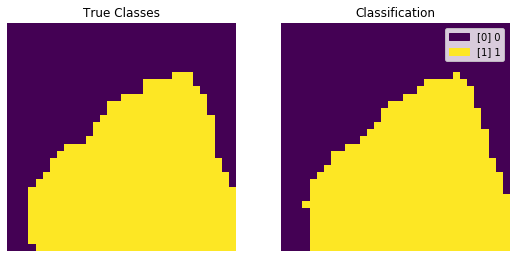

In [10]:
logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1e5)# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

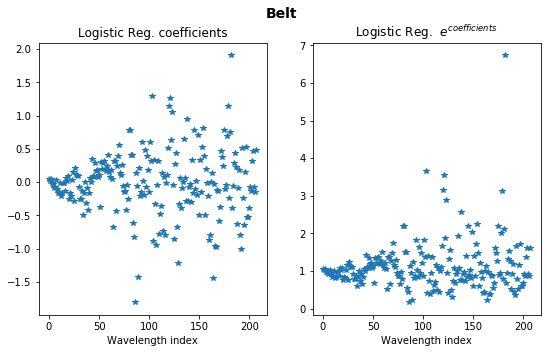

Ordered four most useful wavelengths are: [1584, 1299, 1364, 1361]nm
There corresponding indexes are: [182 103 121 120]


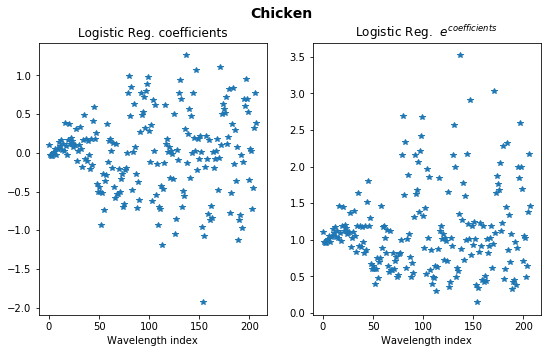

Ordered four most useful wavelengths are: [1422, 1545, 1458, 1216]nm
There corresponding indexes are: [137 171 147  80]


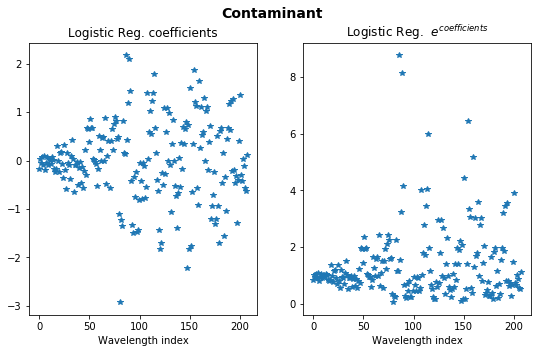

Ordered four most useful wavelengths are: [1238, 1249, 1483, 1339]nm
There corresponding indexes are: [ 86  89 154 114]


In [11]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [12]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [13]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.9158
Epoch 00001: val_loss improved from inf to 0.10203, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 62s 54ms/sample - loss: 0.4084 - accuracy: 0.9160 - val_loss: 0.1020 - val_accuracy: 0.9720
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9703
Epoch 00002: val_loss improved from 0.10203 to 0.07181, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 60s 53ms/sample - loss: 0.1324 - accuracy: 0.9703 - val_loss: 0.0718 - val_accuracy: 0.9792
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9750
Epoch 00003: val_loss improved from 0.07181 to 0.06572, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 60s 53ms/sample - loss: 0.0977 - ac

Epoch 27/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9840
Epoch 00027: val_loss did not improve from 0.04063
1134/1134 [==============================] - 70s 61ms/sample - loss: 0.0464 - accuracy: 0.9840 - val_loss: 0.0496 - val_accuracy: 0.9819
Epoch 28/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9842
Epoch 00028: val_loss did not improve from 0.04063
1134/1134 [==============================] - 66s 58ms/sample - loss: 0.0456 - accuracy: 0.9842 - val_loss: 0.0418 - val_accuracy: 0.9837
Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9843
Epoch 00029: val_loss did not improve from 0.04063
1134/1134 [==============================] - 68s 60ms/sample - loss: 0.0449 - accuracy: 0.9844 - val_loss: 0.0432 - val_accuracy: 0.9840
Epoch 30/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9847
Epoch 00030: val_loss improved from 0.04

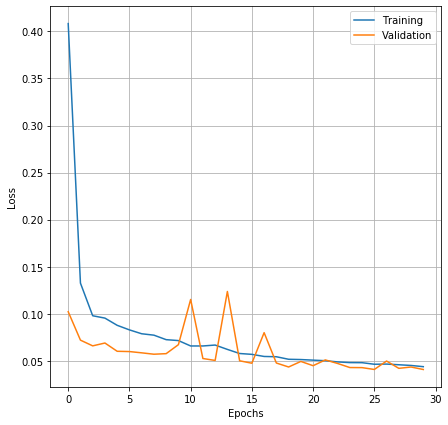

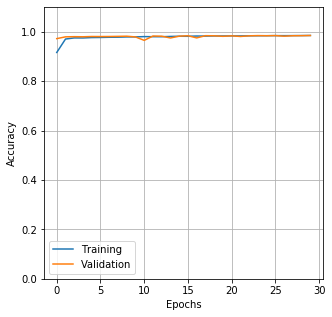

Predicting for train data
Elapsed time: 16.1575 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1068233
           1       0.95      0.97      0.96    208047
           2       0.85      0.57      0.68     13960

    accuracy                           0.99   1290240
   macro avg       0.93      0.84      0.88   1290240
weighted avg       0.99      0.99      0.99   1290240



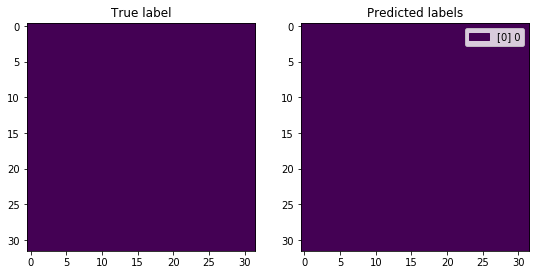

Predicting for test data
Elapsed time: 7.8053 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459515
           1       0.96      0.96      0.96    117070
           2       0.83      0.60      0.69      7095

    accuracy                           0.98    583680
   macro avg       0.93      0.85      0.88    583680
weighted avg       0.98      0.98      0.98    583680



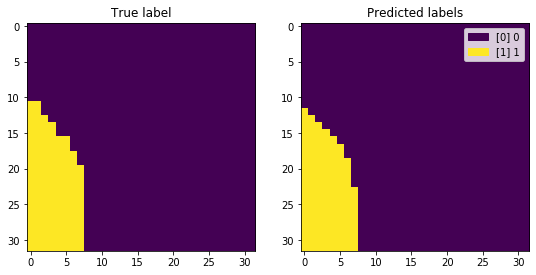

Elapsed time: 8.7428 seconds
Fasle positive blobs 33.
Fasle positive blobs per image 0.0579


In [14]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

### Test 2D UNet on the same data

(1260, 32, 32, 208)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3493 - accuracy: 0.9327
Epoch 00001: val_loss improved from inf to 0.07651, saving model to latest_unet.hdf5
1134/1134 [==============================] - 8s 7ms/sample - loss: 0.3488 - accuracy: 0.9328 - val_loss: 0.0765 - val_accuracy: 0.9781
Epoch 2/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9715
Epoch 00002: val_loss improved from 0.07651 to 0.07087, saving model to latest_unet.hdf5
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.1251 - accuracy: 0.9715 - val_loss: 0.0709 - val_accuracy: 0.9785
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9764
Epoch 00003: val_loss did not improve from 0.07087
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.0866 - accuracy: 0.9765 - val_loss: 0.2800 - val_accuracy: 0

Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9850
Epoch 00029: val_loss did not improve from 0.03865
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.0437 - accuracy: 0.9850 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 30/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9848
Epoch 00030: val_loss did not improve from 0.03865
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.0431 - accuracy: 0.9849 - val_loss: 0.2172 - val_accuracy: 0.9122
Elapsed time: 214.1497 seconds


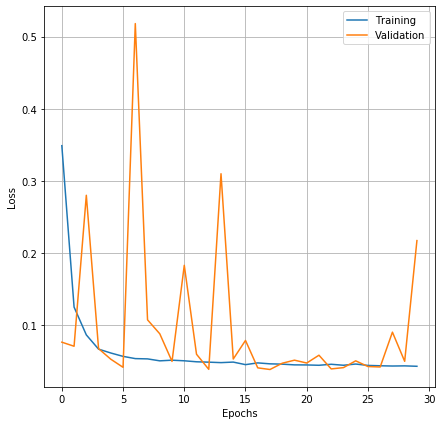

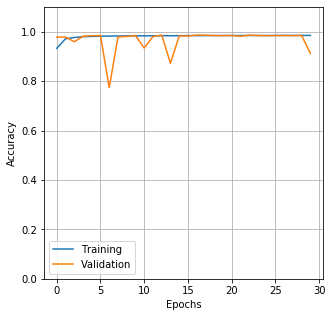

Predicting for train data
Elapsed time: 2.6258 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1068233
           1       0.95      0.97      0.96    208047
           2       0.82      0.59      0.69     13960

    accuracy                           0.99   1290240
   macro avg       0.92      0.85      0.88   1290240
weighted avg       0.99      0.99      0.99   1290240



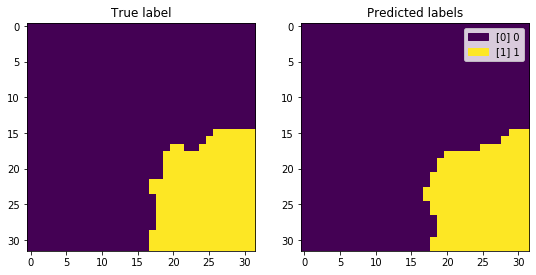

Predicting for test data
Elapsed time: 1.0458 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459515
           1       0.97      0.95      0.96    117070
           2       0.69      0.72      0.71      7095

    accuracy                           0.98    583680
   macro avg       0.88      0.89      0.89    583680
weighted avg       0.98      0.98      0.98    583680



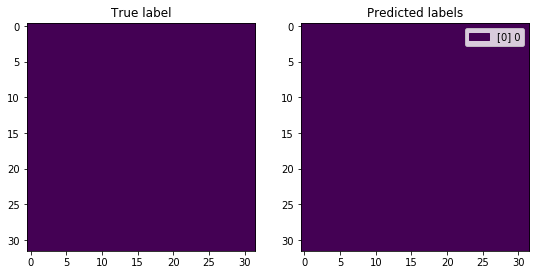

Elapsed time: 1.9962 seconds
Fasle positive blobs 80.
Fasle positive blobs per image 0.1404
Number of layers in the base model:  49


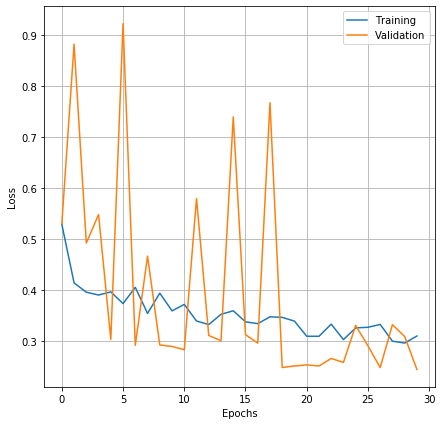

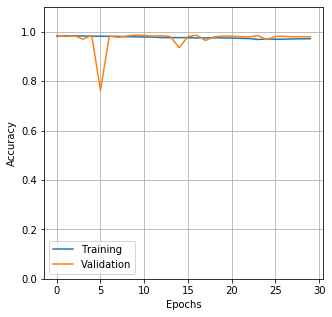

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 1.2692 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    459515
           1       0.99      0.88      0.93    117070
           2       0.77      0.82      0.79      7095

    accuracy                           0.97    583680
   macro avg       0.91      0.90      0.90    583680
weighted avg       0.97      0.97      0.97    583680



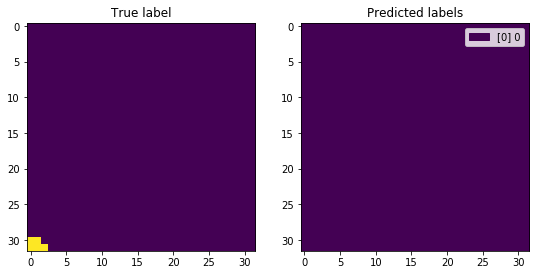

Fasle positive blobs 53.
Fasle positive blobs per image 0.0930


In [15]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [16]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

Number of layers in the base model:  49


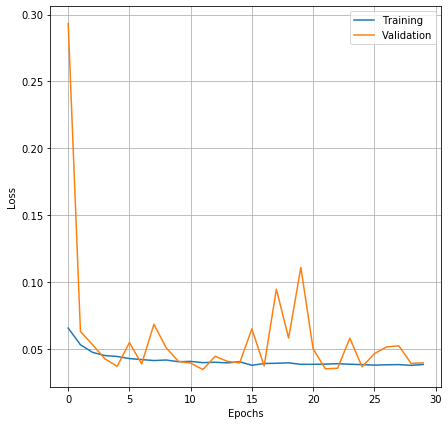

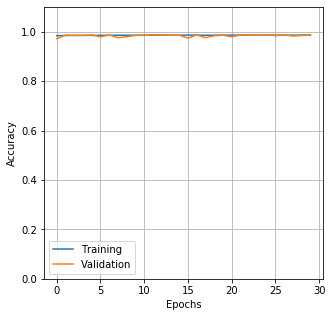

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 1.3574 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459515
           1       0.98      0.94      0.96    117070
           2       0.77      0.81      0.79      7095

    accuracy                           0.98    583680
   macro avg       0.91      0.92      0.92    583680
weighted avg       0.98      0.98      0.98    583680



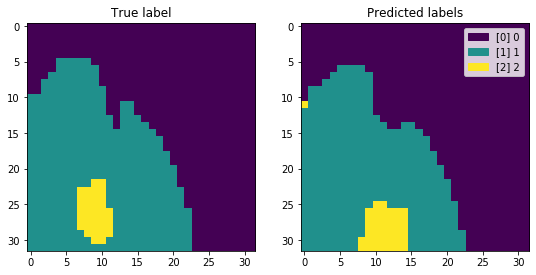

Fasle positive blobs 50.
Fasle positive blobs per image 0.0877


In [17]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [18]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))